In [1]:
# import statements
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, recall_score, accuracy_score
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
from sklearn.metrics import fbeta_score, make_scorer, classification_report, confusion_matrix, recall_score
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier

In [2]:
# read in preprocessed data
df = pd.read_csv('../data/preprocessed/malware_preprocessed.csv')
df = df.drop(df.columns[0], axis=1)

#### Model Selection 

The goal of this classification task is predicting instances of malware. The dataset is imbalanced, meaning there are more positive cases (malware) compared to negative cases. This imbalance can cause challenges with traditional accuracy metrics, which tend to favor the majority class. We aim to prioritize the minimization of false negatives while also preserving as many benign apps as possible. We will use the 3 models below: 

1. CART: CART is a decision tree that uses the Gini index as criterion for splitting. It builds binary trees, meaning each node is split into two child nodes. It includes mechanisms for handling missing values and provides built-in pruning methods to avoid overfitting. It can handle non-linear relationships and interactions between features, making it suitable for capturing complex patterns. It is fairly easy to interpret and visualize.

2. C5.0: This model is an optimized version of C4.5, with fast execution times and improved memory usage. It uses GR to decide on splits. It has advanced boosting techniques and can handle imbalanced datasets.

3. KNN: KNN is a simple yet effective model for classification. It works by classifying an instance based on the majority class of its neighbors. For imbalanced datasets, KNN can perform well if appropriate distance metrics and weighting schemes are applied. KNN is a simple and effective algorithm that does not require training time and can capture complex decision boundaries. While it lacks hyperparameters, it provides a useful benchmark. 

#### Evaluation Metrics

The goal of our algorithm is to capture as many malware cases (minimizing false negatives), while preserving as many benign apps as possible. False negatives (missed instances of malware) are more harmful than false positives (falsely flagging benign apps as malware), however, given the imbalance of the dataset we want to prioritize both precision and recall. Thus, we will use F score as our scoring metric. The F score is a weighted balance of precision and recall. We will use a $\beta > 1$ since we want to prioritize recall. This will allow us to ensure that the model is capturing as many instances of malware as possible without incorrectly flagging benign apps.  

In [7]:
f2_scorer = make_scorer(fbeta_score, beta=2)

#### Split data

Given that the dataset is imbalanced (with fewer benign samples than malicious ones), stratification prevents the training set from being skewed toward the majority class. Without stratification, the model might underrepresent the minority class (benign apps) in the training set, leading to poor performance in preserving benign apps.

The training set will have a balanced representation of both classes and the validation set will accurately reflect the overall class distribution, allowing for better hyperparameter tuning. The test set will also reflect the real-world distribution, making performance evaluation more realistic. Since our goal is to maximize recall (minimize false negatives), maintaining class balance during training and validation is critical.

We will also implement K-Fold cross validation since we have a relatively small dataset (n=4464), with stratification. 

In [10]:
# split data
X = df.drop('Label', axis=1)
y = df['Label']

# split using stratification 
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=7)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=7)

In [11]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Transform the validation and test sets using the same scaler (without fitting again)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [12]:
# implement K-Fold cross-validation since we have a relatively small dataset
skf = StratifiedKFold(n_splits=5)

#### Model 1: CART (Decision Tree)

CART is a simple, interpretable algorithm that can handle imbalanced data. It splits data based on the Gini index, making it effective for classification tasks. 

In [15]:
cart_model = DecisionTreeClassifier()
param_grid = {
    'max_depth': [3, 5, 10, 12],
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf': [1, 2, 5], 
    'class_weight': ['balanced', None],
    'max_features': ['sqrt', None], 
    'ccp_alpha': [0.01, 0.05, 0.1, 0.2] # Add feature limitation
}

grid_search_cart = GridSearchCV(cart_model, param_grid, scoring=f2_scorer, cv=skf)
grid_search_cart.fit(X_train, y_train)

# Use the validation set for hyperparameter tuning
best_cart_model = grid_search_cart.best_estimator_
print(f"Best Hyperparameters: {grid_search_cart.best_params_}")

# Evaluate the best model using cross-validation on the training data
cross_val_scores = cross_val_score(best_cart_model, X_train, y_train, cv=skf, scoring=f2_scorer)
print(f"Cross-validation ROC AUC scores (TRAINING): {cross_val_scores}")
print(f"Mean ROC AUC (TRAINING): {cross_val_scores.mean():.3f}")

# Evaluate the best model on the validation set
val_preds = best_cart_model.predict(X_val)
print("Validation Classification Report:\n", classification_report(y_val, val_preds))
print("Validation Confusion Matrix:\n", confusion_matrix(y_val, val_preds))

# Calculate and print recall on the validation set
val_recall = recall_score(y_val, val_preds)
print(f"Validation Recall: {val_recall:.3f}")

Best Hyperparameters: {'ccp_alpha': 0.01, 'class_weight': None, 'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5}
Cross-validation ROC AUC scores (TRAINING): [0.94686376 0.96046326 0.94848243 0.95276221 0.95991984]
Mean ROC AUC (TRAINING): 0.954
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96       534
           1       0.97      0.93      0.95       535

    accuracy                           0.96      1069
   macro avg       0.96      0.96      0.96      1069
weighted avg       0.96      0.96      0.96      1069

Validation Confusion Matrix:
 [[521  13]
 [ 35 500]]
Validation Recall: 0.935


In [16]:
# Evaluate CART

best_cart_model.fit(X_train, y_train)

cart_preds = best_cart_model.predict(X_test)
print("CART Classification Report:\n", classification_report(y_test, cart_preds))
print("CART Confusion Matrix:\n", confusion_matrix(y_test, cart_preds))

# Calculate and print recall
cart_recall = recall_score(y_test, cart_preds)
print(f"CART Recall: {cart_recall:.3f}")

CART Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.91      0.92       535
           1       0.91      0.93      0.92       535

    accuracy                           0.92      1070
   macro avg       0.92      0.92      0.92      1070
weighted avg       0.92      0.92      0.92      1070

CART Confusion Matrix:
 [[485  50]
 [ 38 497]]
CART Recall: 0.929


In [17]:
# Prune the tree using the cost-complexity pruning path
path = best_cart_model.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas  # Values of alpha for pruning

# Test different pruning strategies (find optimal alpha)
for alpha in ccp_alphas:
    model = DecisionTreeClassifier(ccp_alpha=alpha)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print(f"Alpha: {alpha}, Accuracy: {accuracy_score(y_test, preds)}")

Alpha: 0.0, Accuracy: 0.9934579439252337
Alpha: 5.692455148787216e-06, Accuracy: 0.991588785046729
Alpha: 2.1577300679685035e-05, Accuracy: 0.991588785046729
Alpha: 2.7541817787283525e-05, Accuracy: 0.991588785046729
Alpha: 6.667463619388801e-05, Accuracy: 0.991588785046729
Alpha: 9.686857831700361e-05, Accuracy: 0.991588785046729
Alpha: 0.0001155118513941695, Accuracy: 0.9934579439252337
Alpha: 0.00013218237271533188, Accuracy: 0.991588785046729
Alpha: 0.00019551321410797486, Accuracy: 0.991588785046729
Alpha: 0.0001991312386231383, Accuracy: 0.991588785046729
Alpha: 0.00023765855462910143, Accuracy: 0.991588785046729
Alpha: 0.0003434753985745772, Accuracy: 0.991588785046729
Alpha: 0.00036429208939727875, Accuracy: 0.991588785046729
Alpha: 0.0003840245775729649, Accuracy: 0.991588785046729
Alpha: 0.00039002712988300933, Accuracy: 0.991588785046729
Alpha: 0.000393812310434645, Accuracy: 0.991588785046729
Alpha: 0.00039602070684173154, Accuracy: 0.991588785046729
Alpha: 0.00039724664700

#### Model 2: C5.0 (XGBoost)

C5.0 (via XGBoost) is known for high accuracy and can naturally handle imbalance. It also supports regularization and boosting, reducing overfitting. 

In [20]:
xgb_model = xgb.XGBClassifier(objective='binary:logistic', scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]))
param_grid_xgb = {
    'max_depth': [5, 10, 15],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 200], 
    'gamma': [0.1, 0.5, 1],  # Control pruning with gamma
    'min_child_weight': [1, 3, 5]  # Controls the minimum weight needed for a child
}
grid_search_xgb = GridSearchCV(xgb_model, param_grid_xgb, scoring=f2_scorer, cv=skf)
grid_search_xgb.fit(X_train, y_train)

# Use the validation set for hyperparameter tuning
best_xgb_model = grid_search_xgb.best_estimator_
print(f"Best Hyperparameters: {grid_search_xgb.best_params_}")


# Evaluate the best model using cross-validation on the training data
cross_val_scores = cross_val_score(best_xgb_model, X_train, y_train, cv=skf, scoring=f2_scorer)
print(f"Cross-validation ROC AUC scores (TRAINING): {cross_val_scores}")
print(f"Mean ROC AUC (TRAINING): {cross_val_scores.mean():.3f}")

# Evaluate the best model using cross-validation on the training data
cross_val_scores = cross_val_score(best_xgb_model, X_train, y_train, cv=skf, scoring=f2_scorer)
print(f"Cross-validation ROC AUC scores (TRAINING): {cross_val_scores}")
print(f"Mean ROC AUC (TRAINING): {cross_val_scores.mean():.3f}")

# Evaluate the best model on the validation set
val_preds = best_xgb_model.predict(X_val)
print("Validation Classification Report:\n", classification_report(y_val, val_preds))
print("Validation Confusion Matrix:\n", confusion_matrix(y_val, val_preds))

# Calculate and print recall on the validation set
val_recall = recall_score(y_val, val_preds)
print(f"Validation Recall: {val_recall:.3f}")

# Evaluate XGBoost

best_xgb_model.fit(X_train, y_train)

xgb_preds = best_xgb_model.predict(X_test)
print("XGBoost Classification Report:\n", classification_report(y_test, xgb_preds))
print("XGBoost Confusion Matrix:\n", confusion_matrix(y_test, xgb_preds))

# Calculate and print recall
xgb_recall = recall_score(y_test, xgb_preds)
print(f"XGBoost Recall: {xgb_recall:.3f}")


Best Hyperparameters: {'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 100}
Cross-validation ROC AUC scores (TRAINING): [0.99198397 0.99639856 0.99599198 0.99559295 0.99520384]
Mean ROC AUC (TRAINING): 0.995
Cross-validation ROC AUC scores (TRAINING): [0.99198397 0.99639856 0.99599198 0.99559295 0.99520384]
Mean ROC AUC (TRAINING): 0.995
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       534
           1       1.00      0.99      0.99       535

    accuracy                           0.99      1069
   macro avg       0.99      0.99      0.99      1069
weighted avg       0.99      0.99      0.99      1069

Validation Confusion Matrix:
 [[532   2]
 [  4 531]]
Validation Recall: 0.993
XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       535
           1       0.99      0.99  

#### Model 3: K-Nearest Neighbors (KNN)

KNN is a simple and effective algorithm that does not require training time and can capture complex decision boundaries. While it lacks hyperparameters, it provides a useful benchmark. 

In [23]:
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)

# Evaluate KNN
knn_preds = knn_model.predict(X_test)
print("KNN Classification Report:\n", classification_report(y_test, knn_preds))
print("KNN Confusion Matrix:\n", confusion_matrix(y_test, knn_preds))

# Calculate and print recall
knn_recall = recall_score(y_test, knn_preds)
print(f"KNN Recall: {knn_recall:.3f}")

KNN Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       535
           1       0.99      0.99      0.99       535

    accuracy                           0.99      1070
   macro avg       0.99      0.99      0.99      1070
weighted avg       0.99      0.99      0.99      1070

KNN Confusion Matrix:
 [[531   4]
 [  3 532]]
KNN Recall: 0.994


#### Model Interpretability

I used SHAP (SHapley Additive exPlanations) for model interpretability because it provides clear and consistent explanations for the predictions made by complex machine learning models. 

SHAP calculates the contribution of each feature to the prediction (positive or negative). If a feature significantly increases the likelihood of an app being classified as malicious, it will have a strong positive SHAP value.

Plots: 
- Force Plot: This visualizes how much each feature pushes the model's output toward predicting either "benign" or "malicious."
- Summary Plot: It shows the average impact of each feature across all predictions, helping identify the most influential predictors in the model.

This approach ensures that security analysts can understand which app characteristics are most indicative of malware, helping improve threat detection and prevention strategies.

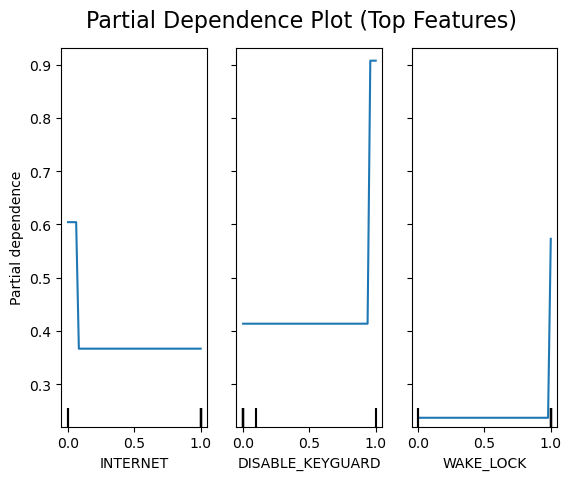

In [26]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

importances = best_cart_model.feature_importances_
indices = np.argsort(importances)[::-1]  # Sort the indices of features by importance

# Get the top 10 most important features
top_n = 3
top_indices = indices[:top_n]

# Get the names or indices of the most important features
top_feature_columns = X_train.columns[top_indices]  # If X_train is a DataFrame

# Plot PDP for the top features
disp = PartialDependenceDisplay.from_estimator(best_cart_model, X_train, features=top_feature_columns, grid_resolution=50)

# Add title and improve readability
plt.suptitle("Partial Dependence Plot (Top Features)", fontsize=16)
plt.subplots_adjust(top=0.9)  # Adjust title position
plt.show()

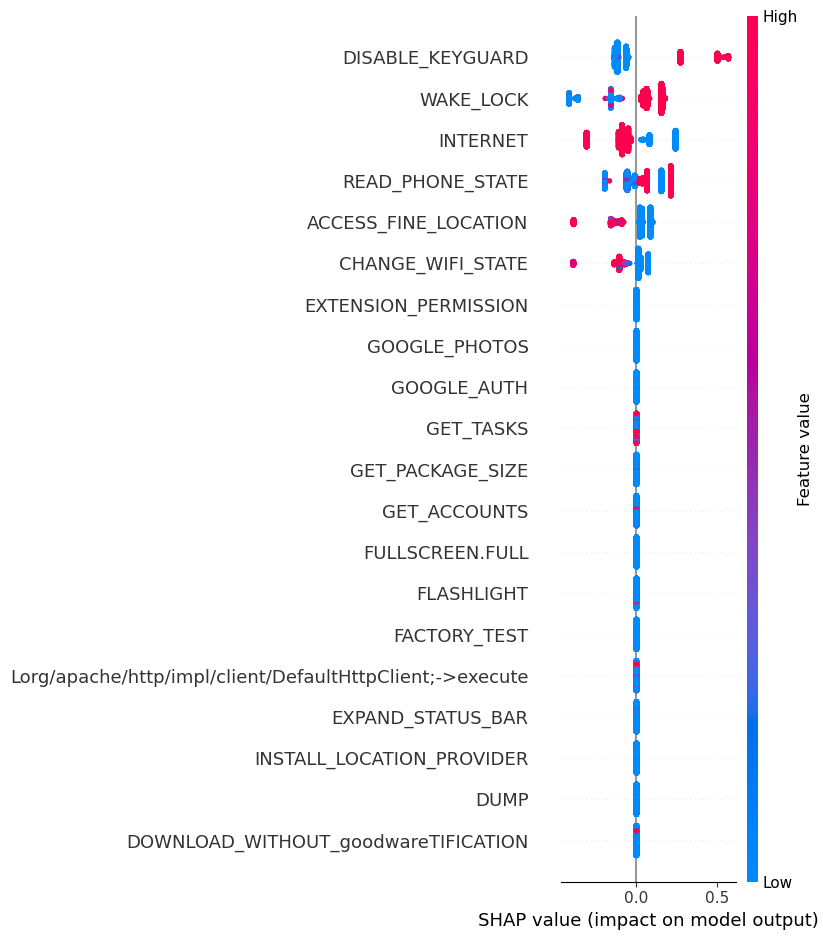

In [27]:
# Create SHAP explainer for the model
explainer = shap.TreeExplainer(best_cart_model)

# Calculate SHAP values for the training set
shap_values = explainer.shap_values(X_train)

# Extract SHAP values for the positive class (malware = 1)
shap_values_positive_class = shap_values[:, :, 1]

# SHAP summary plot for the positive class (malware detection)
shap.summary_plot(shap_values_positive_class, X_train)

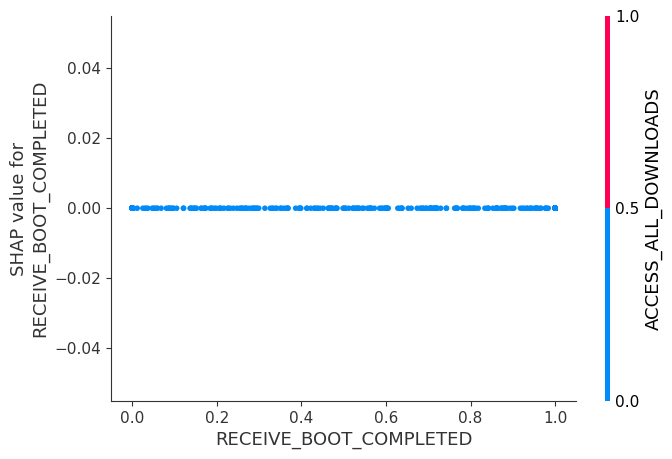

In [28]:
# SHAP dependence plot for a specific feature (e.g., 'feature_name')
shap.dependence_plot('RECEIVE_BOOT_COMPLETED', shap_values_positive_class, X_train)

# SHAP force plot for a specific instance (e.g., the first instance in the dataset)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values_positive_class[0], X_train.iloc[0])

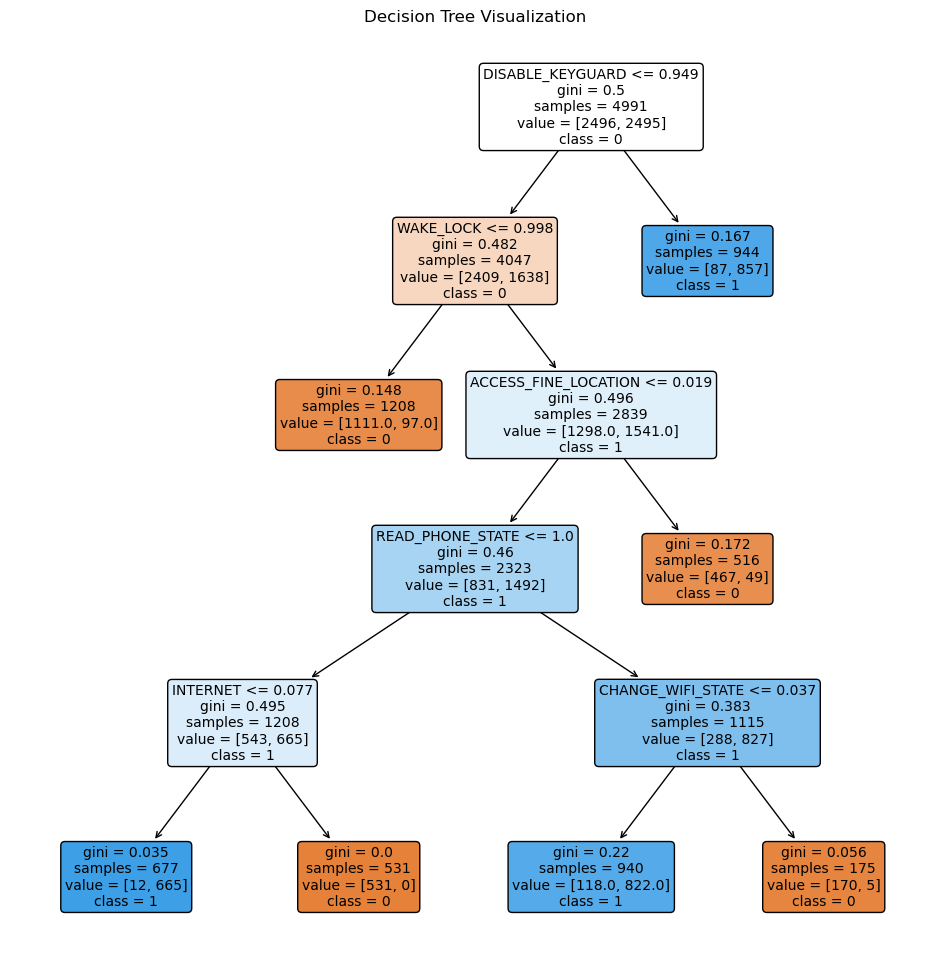

In [29]:
# Visualize the tree using sklearn
plt.figure(figsize=(12, 12))
plot_tree(
    best_cart_model, 
    feature_names=X_train.columns,        # Set feature names
    class_names=[str(cls) for cls in sorted(set(y_train))],  # Ensure class names are strings and sorted
    filled=True,                           # Color the nodes based on class
    rounded=True,                          # Rounded corners for the nodes
    fontsize=10,                           # Font size for labels
    max_depth=5                           # Limit tree depth for better visualization (you can adjust this)
)
plt.title("Decision Tree Visualization")
plt.show()

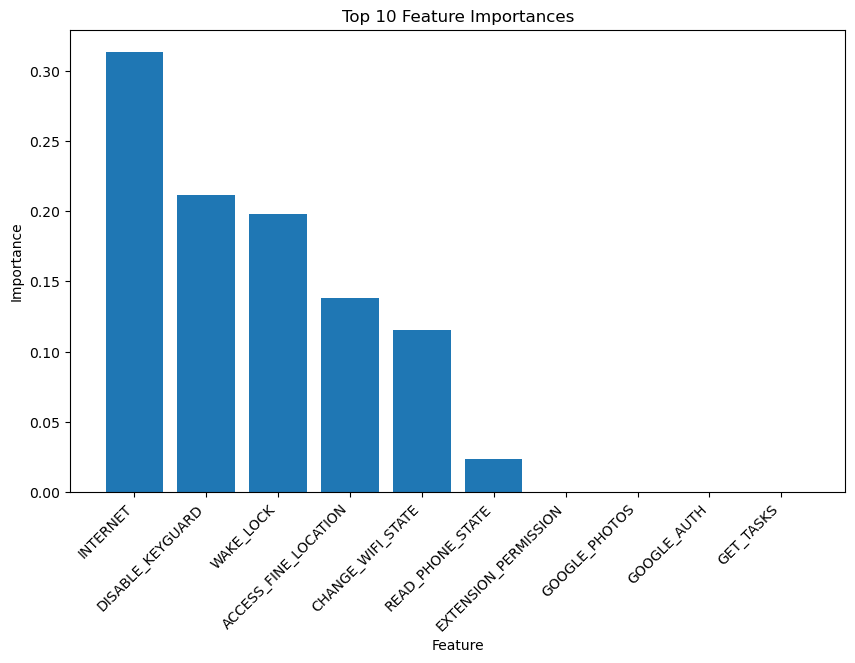

In [30]:
# Get the feature importances and sort them in descending order
importances = best_cart_model.feature_importances_
indices = np.argsort(importances)[::-1]  # Sort the indices of features by importance

# Get the top 10 most important features
top_n = 10
top_indices = indices[:top_n]

# Plot the top 10 most important features
plt.figure(figsize=(10, 6))
plt.bar(X_train.columns[top_indices], importances[top_indices])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title(f'Top {top_n} Feature Importances')
plt.xticks(rotation=45, ha="right")  # Rotate the feature names for better visibility
plt.show()

#### Results and Conclusion 

In [32]:
# Calculate F2 score for each model using predict_proba and thresholding at 0.5
cart_f2 = fbeta_score(y_test, best_cart_model.predict_proba(X_test)[:, 1] > 0.5, beta=2)
xgb_f2 = fbeta_score(y_test, best_xgb_model.predict_proba(X_test)[:, 1] > 0.5, beta=2)
knn_f2 = fbeta_score(y_test, knn_model.predict_proba(X_test)[:, 1] > 0.5, beta=2)

# Print the results
print(f"CART F-METRIC: {cart_f2:.3f}")
print(f"XGBoost F-METRIC: {xgb_f2:.3f}")
print(f"KNN F-METRIC: {knn_f2:.3f}")

CART F-METRIC: 0.925
XGBoost F-METRIC: 0.994
KNN F-METRIC: 0.994


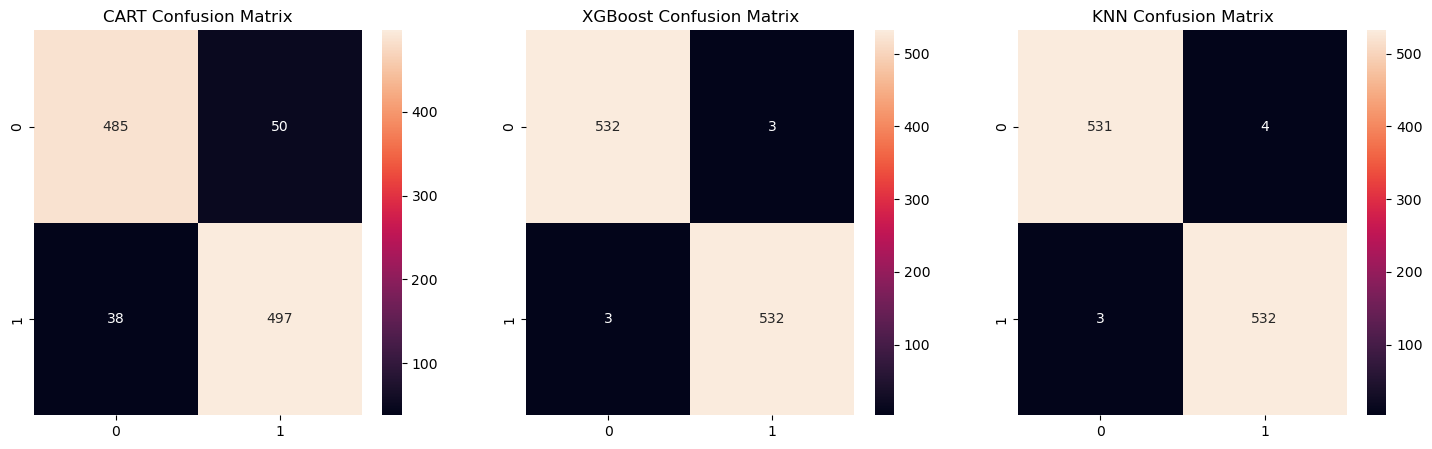

In [33]:
# Confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.heatmap(confusion_matrix(y_test, cart_preds), annot=True, fmt='d', ax=axes[0])
axes[0].set_title('CART Confusion Matrix')
sns.heatmap(confusion_matrix(y_test, xgb_preds), annot=True, fmt='d', ax=axes[1])
axes[1].set_title('XGBoost Confusion Matrix')
sns.heatmap(confusion_matrix(y_test, knn_preds), annot=True, fmt='d', ax=axes[2])
axes[2].set_title('KNN Confusion Matrix')
plt.show()